In [63]:
import json
import re
import numpy as np
from collections import defaultdict

In [60]:
import matplotlib.pyplot as plt

In [30]:
with open('master_results.json') as f:
    master_results = json.load(f)

In [19]:
from copy import deepcopy

In [24]:
master_results_copy = deepcopy(master_results)

In [25]:
for model, model_value in master_results.items():
    for input_size, input_value in model_value['false'].items():
        for hardware, hardware_value in input_value.items():
            for time_type, time_value in hardware_value.items():
                if isinstance(time_value, list):
                    master_results_copy[model]['false'][input_size][hardware][time_type] = {'mean': time_value[0], 'std': time_value[1]}

In [29]:
with open('master_results.json', 'w+') as f:
    json.dump(master_results_copy, f)

In [119]:
with open('cpu_results_updated.json') as f:
    cpu_results = json.load(f)

with open('v100_results.json') as f:
    v100_results = json.load(f)
    
with open('v100_results_optim.json') as f:
    v100_results_optim = json.load(f)

In [122]:
from jsonmerge import merge

In [125]:
master_results_updated = merge(cpu_results, v100_results)
master_results_updated = merge(master_results_updated, v100_results_optim)

In [126]:
with open('master_results_updated.json', 'w+') as f:
    json.dump(master_results_updated, f)

In [233]:
def plot_all_models(results, plotter, title, **kwargs):
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    fig.suptitle(title)
    
    models = [['bert-base', 'distilbert'], ['electra-small', 'bert-tiny']]

    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            model_name = models[i][j]
            plotter(results[model_name], model_name, col, **kwargs)
    plt.show()

## Effect of Input Size

In [127]:
def analyze_batch_size(model_results):
    input_sizes = []
    values = defaultdict(list)
    stddevs = defaultdict(list)
    for input_size, input_value in model_results.items():
        bs, sl = re.search('bs(\d+)_sl(\d+)', input_size).groups()
        bs, sl = int(bs), int(sl)
        input_sizes.append(bs * sl)
        for hardware, hardware_value in input_value.items():
            values[hardware].append(hardware_value['total_time']['mean'])
            stddevs[hardware].append(hardware_value['total_time']['std'])
    
    sorted_means = dict()
    sorted_stds = dict()
    for hardware, hardware_value in values.items():
        value_zip = list(zip(input_sizes, hardware_value, stddevs[hardware]))
        value_zip.sort()
        _, sorted_mean, sorted_std = zip(*value_zip)
        sorted_means[hardware] = sorted_mean
        sorted_stds[hardware] = sorted_std
                
    for hardware, hardware_means in sorted_means.items():
        plt.errorbar(sorted(input_sizes), hardware_means, yerr=sorted_stds[hardware])
    plt.legend(values.keys())
    plt.xlabel('Input Size (Batch Size x Sequence Length)')
    plt.ylabel('Total Mean Inference Time (s)')
    plt.show()

In [240]:
def analyze_batch_size_plot(model_results, model_name, plot, onnx_opt='false'):
    results = model_results[onnx_opt]
    
    input_sizes = []
    values = defaultdict(list)
    stddevs = defaultdict(list)
    for input_size, input_value in results.items():
        bs, sl = re.search('bs(\d+)_sl(\d+)', input_size).groups()
        bs, sl = int(bs), int(sl)
        input_sizes.append(bs * sl)
        for hardware, hardware_value in input_value.items():
            values[hardware].append(hardware_value['total_time']['mean'])
            stddevs[hardware].append(hardware_value['total_time']['std'])
    
    sorted_means = dict()
    sorted_stds = dict()
    for hardware, hardware_value in values.items():
        value_zip = list(zip(input_sizes, hardware_value, stddevs[hardware]))
        value_zip.sort()
        _, sorted_mean, sorted_std = zip(*value_zip)
        sorted_means[hardware] = sorted_mean
        sorted_stds[hardware] = sorted_std
                
    for hardware, hardware_means in sorted_means.items():
        plot.errorbar(sorted(input_sizes), hardware_means, yerr=sorted_stds[hardware])
    plot.legend(values.keys())
    plot.set_xlabel('Input Size (Batch Size x Sequence Length)')
    plot.set_ylabel('Total Mean Inference Time (s)')
    plot.set_title(model_name)

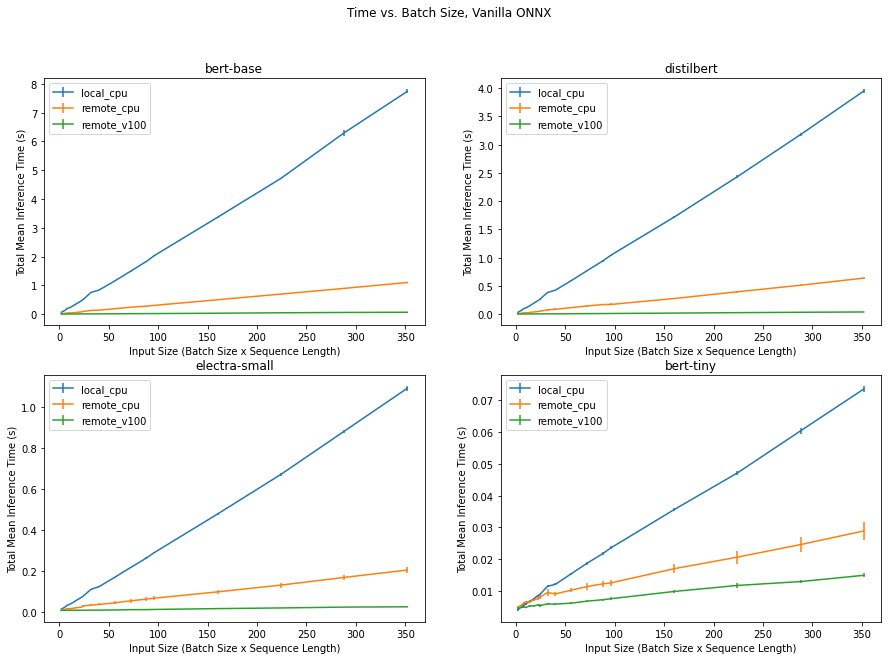

In [234]:
plot_all_models(master_results_updated, analyze_batch_size_plot, "Time vs. Batch Size, Vanilla ONNX", onnx_opt='false')

In [255]:
def analyze_batch_size_plot_all(master_results, onnx_opt='false'):
    plt.figure(figsize=(20,15))
    labels = []
    for model, model_results in master_results.items():
        results = model_results[onnx_opt]

        input_sizes = []
        values = defaultdict(list)
        stddevs = defaultdict(list)
        for input_size, input_value in results.items():
            bs, sl = re.search('bs(\d+)_sl(\d+)', input_size).groups()
            bs, sl = int(bs), int(sl)
            input_sizes.append(bs * sl)
            for hardware, hardware_value in input_value.items():
                values[hardware].append(hardware_value['total_time']['mean'])
                stddevs[hardware].append(hardware_value['total_time']['std'])

        sorted_means = dict()
        sorted_stds = dict()
        for hardware, hardware_value in values.items():
            value_zip = list(zip(input_sizes, hardware_value, stddevs[hardware]))
            value_zip.sort()
            _, sorted_mean, sorted_std = zip(*value_zip)
            sorted_means[hardware] = sorted_mean
            sorted_stds[hardware] = sorted_std

        for hardware, hardware_means in sorted_means.items():
            plt.errorbar(sorted(input_sizes), hardware_means, yerr=sorted_stds[hardware])
            labels.append(f"{model}-{hardware}")
            
    plt.legend(labels)
    plt.xlabel('Input Size (Batch Size x Sequence Length)')
    plt.ylabel('Total Mean Inference Time (s)')
    plt.yscale('log')
    plt.xscale('log')
#     plt.set_title(model_name)
    plt.show()

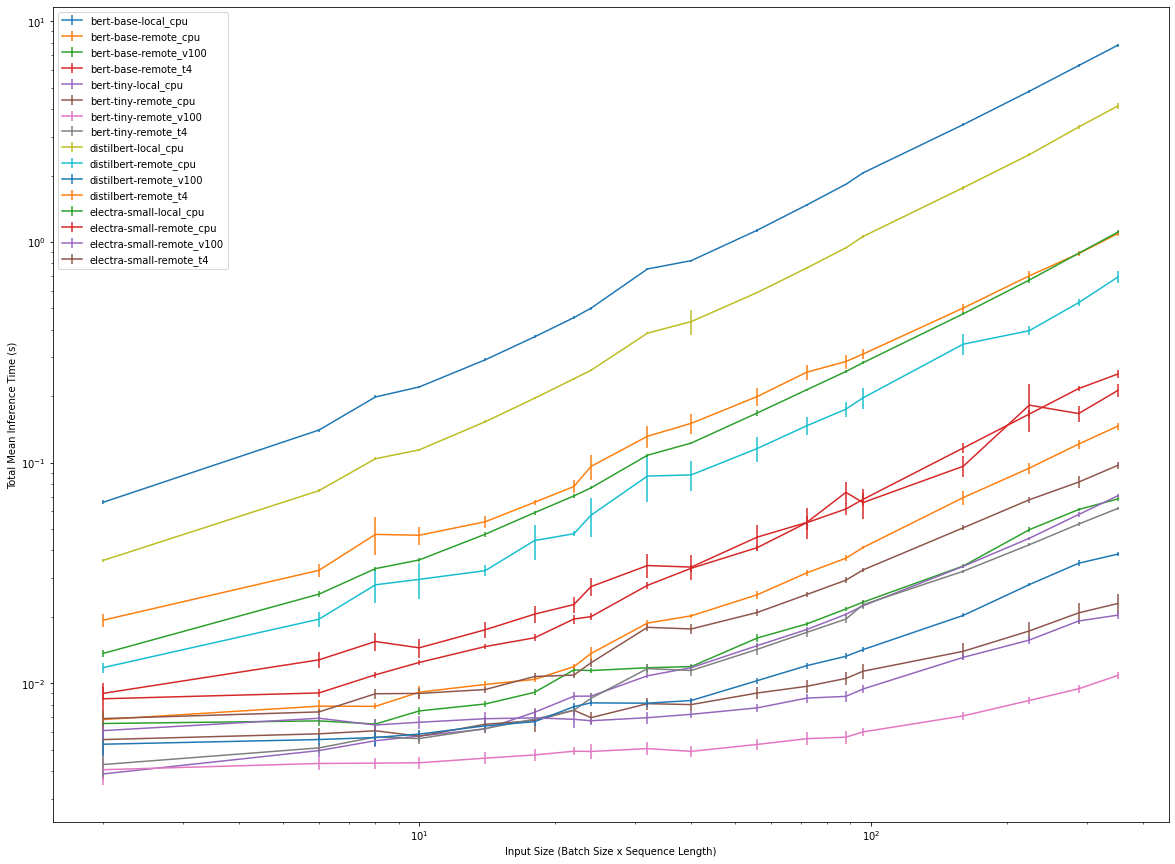

In [256]:
analyze_batch_size_plot_all(master_results, onnx_opt='false')

In [287]:
def plot_at_input_size(master_results, input_size='bs32_sl3', onnx_opt='false'):
    plt.figure(figsize=(20,15))
    labels = []
    
    values = dict()
    stddevs = dict()
    for model, model_results in master_results.items():
        results = model_results[onnx_opt]

        input_value = results[input_size]
        for hardware, hardware_value in input_value.items():
            values[f"{model}\n{hardware}"] = hardware_value['total_time']['mean']
            stddevs[f"{model}\n{hardware}"] = hardware_value['total_time']['std']

#         sorted_means = dict()
#         sorted_stds = dict()
#         for hardware, hardware_value in values.items():
#             value_zip = list(zip(input_sizes, hardware_value, stddevs[hardware]))
#             value_zip.sort()
#             _, sorted_mean, sorted_std = zip(*value_zip)
#             sorted_means[hardware] = sorted_mean
#             sorted_stds[hardware] = sorted_std

    labels = list(values.keys())
    x = np.arange(len(labels))
    width = 0.35  # the width of the bars  

    rects1 = plt.bar(x, values.values(), width, yerr=stddevs.values())
            
    plt.ylabel('Log Total Mean Inference Time (s)')
    plt.xticks(x, labels)
    plt.yscale('log')

    plt.bar_label(rects1, fmt="%.4f", padding=3)
    plt.show()

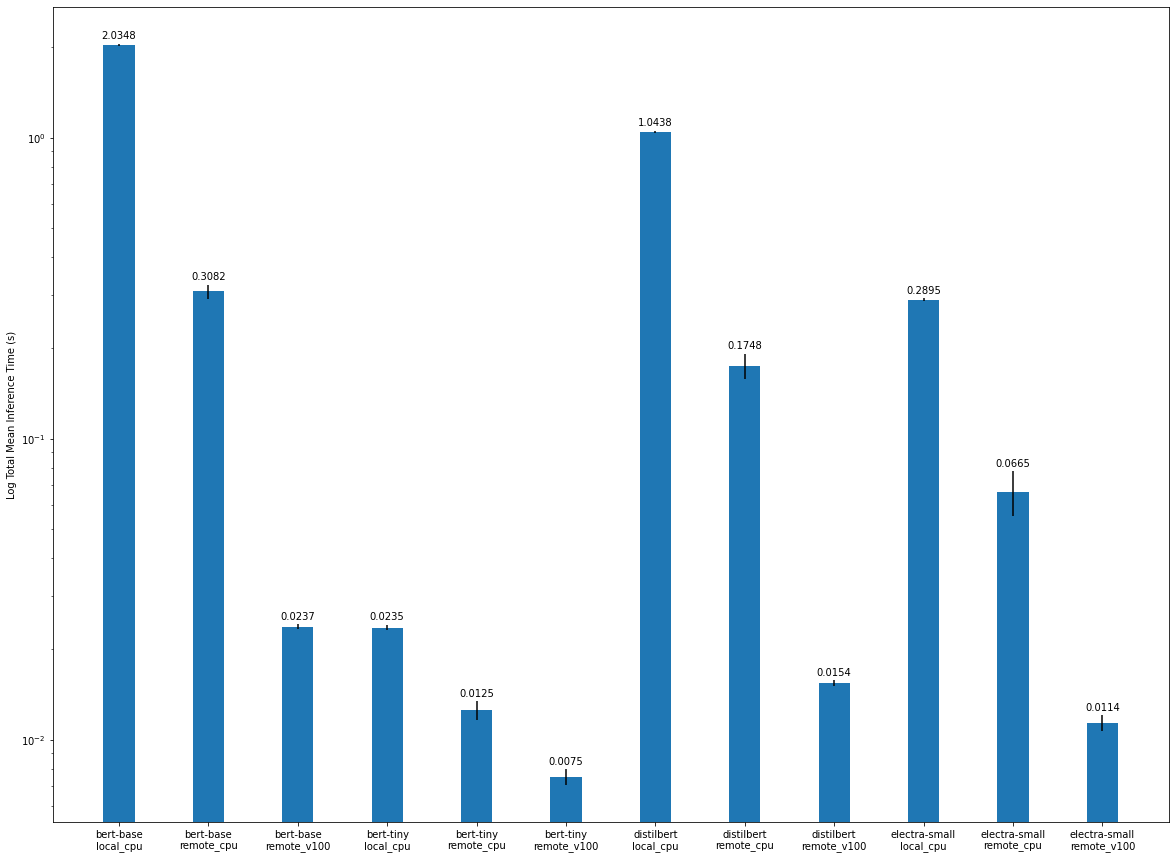

In [288]:
plot_at_input_size(master_results_updated, input_size='bs32_sl3', onnx_opt='false')

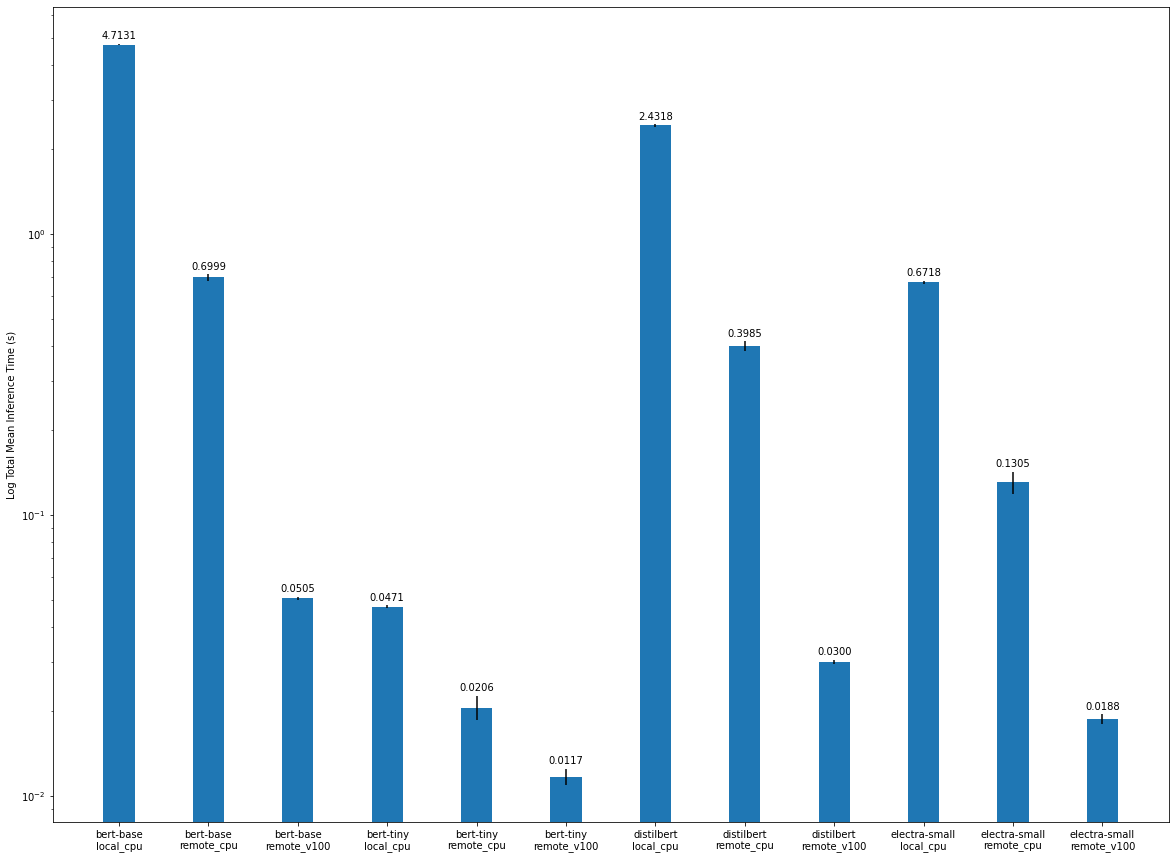

In [289]:
plot_at_input_size(master_results_updated, input_size='bs32_sl7', onnx_opt='false')

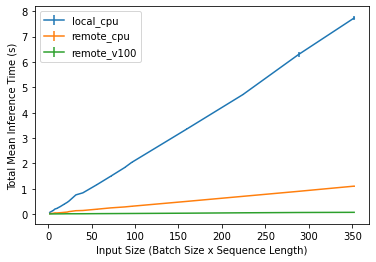

In [128]:
analyze_batch_size(master_results_updated['bert-base']['false'])

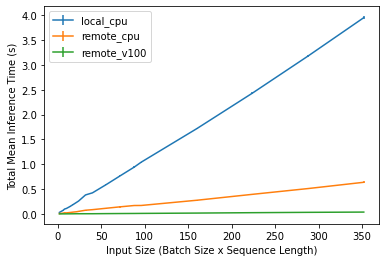

In [129]:
analyze_batch_size(master_results_updated['distilbert']['false'])

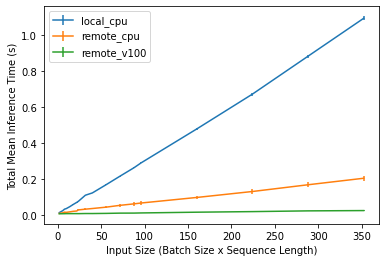

In [130]:
analyze_batch_size(master_results_updated['electra-small']['false'])

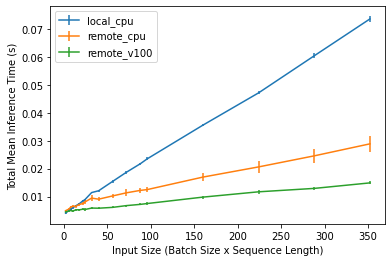

In [131]:
analyze_batch_size(master_results_updated['bert-tiny']['false'])

## ONNX Quantization (CPU) vs. Optimization (GPU)

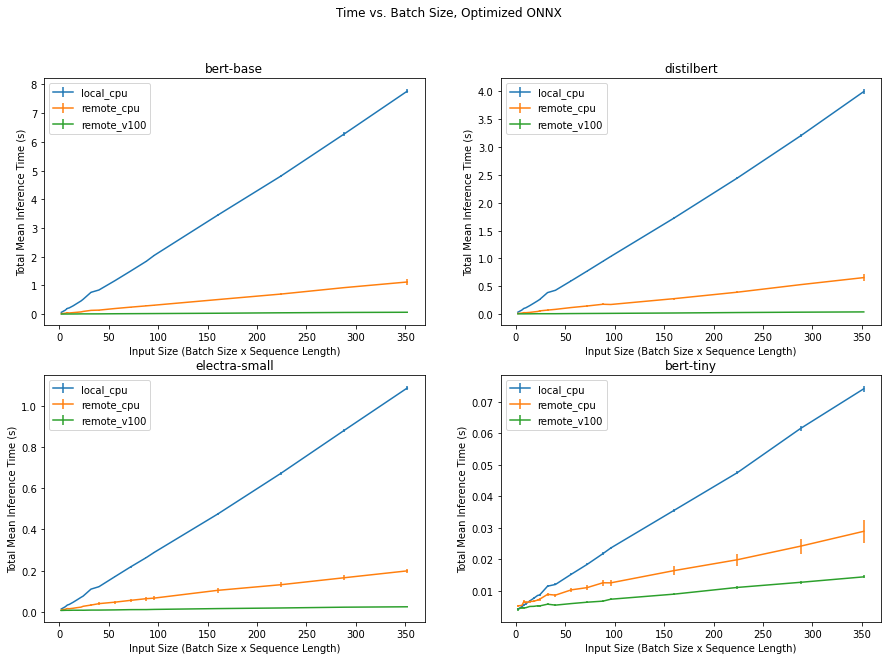

In [236]:
plot_all_models(master_results_updated, analyze_batch_size_plot, "Time vs. Batch Size, Optimized ONNX", onnx_opt='true')

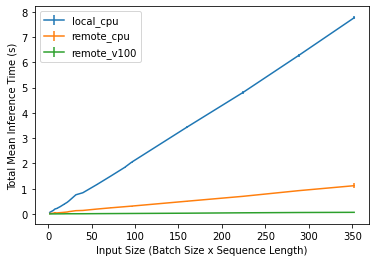

In [132]:
analyze_batch_size(master_results_updated['bert-base']['true'])

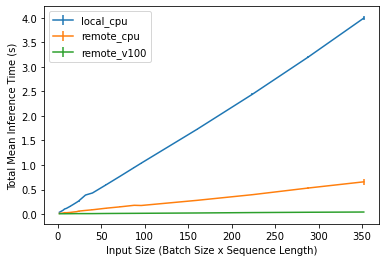

In [133]:
analyze_batch_size(master_results_updated['distilbert']['true'])

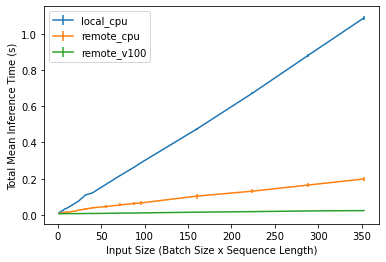

In [134]:
analyze_batch_size(master_results_updated['electra-small']['true'])

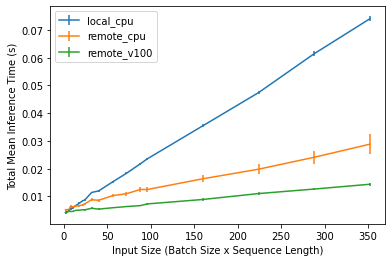

In [135]:
analyze_batch_size(master_results_updated['bert-tiny']['true'])

In [178]:
def analyze_optim(model_results):
    vanilla_values = dict()
    vanilla_std = dict()
    
    optim_values = dict()
    optim_std = dict()
    
    for hardware, hardware_value in model_results['false']['bs32_sl11'].items():
        vanilla_values[hardware] = hardware_value['total_time']['mean']
        vanilla_std[hardware] = hardware_value['total_time']['std']
    for hardware, hardware_value in model_results['true']['bs32_sl11'].items():
        optim_values[hardware] = hardware_value['total_time']['mean']
        optim_std[hardware] = hardware_value['total_time']['std']
    
    labels = list(vanilla_values.keys())
    x = np.arange(len(labels))
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter("{x:.3f}")
    rects1 = ax.bar(x - width/2, vanilla_values.values(), width, yerr=vanilla_std.values(), label='Vanilla')
    rects2 = ax.bar(x + width/2, optim_values.values(), width, yerr=optim_std.values(), label='Optim')
    

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Time (s)')
    ax.set_title('Effect of ONNX Optimization')
    ax.set_xticks(x, labels)
    ax.legend()

    ax.bar_label(rects1, fmt="%.4f", padding=3)
    ax.bar_label(rects2, fmt="%.4f", padding=3)

    fig.tight_layout()
    
    ax.margins(0.1)

    plt.show()

In [220]:
def analyze_optim_plot(model_results, model_name, plot):
    vanilla_values = dict()
    vanilla_std = dict()
    
    optim_values = dict()
    optim_std = dict()
    
    for hardware, hardware_value in model_results['false']['bs32_sl11'].items():
        vanilla_values[hardware] = hardware_value['total_time']['mean']
        vanilla_std[hardware] = hardware_value['total_time']['std']
    for hardware, hardware_value in model_results['true']['bs32_sl11'].items():
        optim_values[hardware] = hardware_value['total_time']['mean']
        optim_std[hardware] = hardware_value['total_time']['std']
    
    labels = list(vanilla_values.keys())
    x = np.arange(len(labels))
    width = 0.35  # the width of the bars

    plot.yaxis.set_major_formatter("{x:.3f}")
    rects1 = plot.bar(x - width/2, vanilla_values.values(), width, yerr=vanilla_std.values(), label='Vanilla')
    rects2 = plot.bar(x + width/2, optim_values.values(), width, yerr=optim_std.values(), label='Optim')
    

    # Add some text for labels, title and custom x-axis tick labels, etc.
    plot.set_ylabel('Total Mean Inference Time (s)')
    plot.set_title(model_name)
    plot.set_xticks(x, labels)
    plot.legend()

    plot.bar_label(rects1, fmt="%.4f", padding=3)
    plot.bar_label(rects2, fmt="%.4f", padding=3)
    
    plot.margins(0.1)

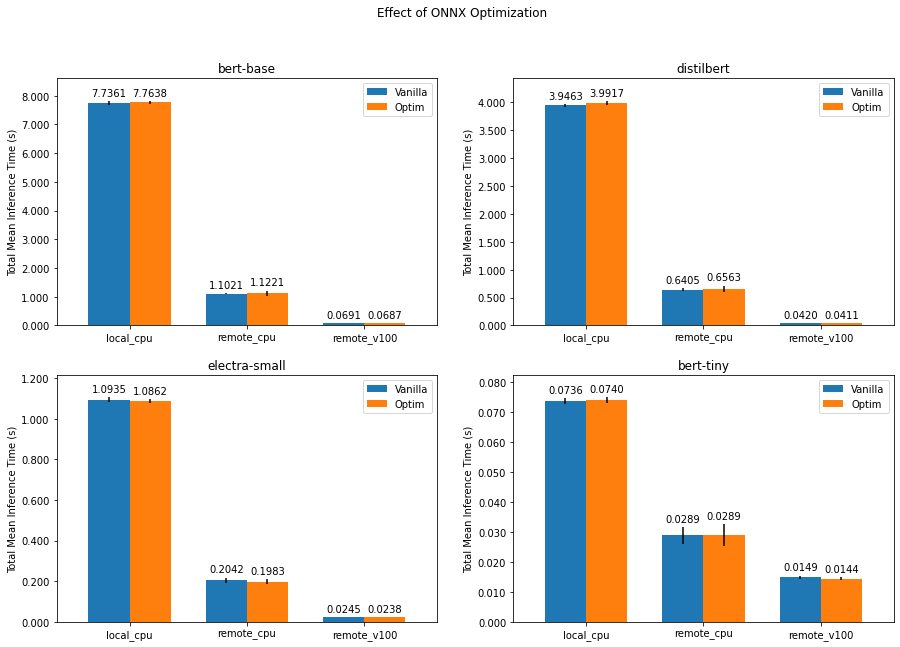

In [237]:
plot_all_models(master_results_updated, analyze_optim_plot, "Effect of ONNX Optimization")